타이타닉 데이터는 머신러닝을 학습하는 사람에게는 익숙한 데이터일 것이라고 생각합니다. 저도 머신러닝을 처음 배울 때, 이 데이터로 실습을 했던 기억이 납니다. 오늘은 제가 2020년 7월에 첫 머신러닝 프로젝트를 했을 당시에 작성했던 코드를 살펴보면서 정리하는 시간을 가져보려고 합니다.\
\
과거에 작성했던 코드를 크게 수정하지 않고, 부족한 점이 있다면 현재 시점에서는 어떻게 작업했을 지에 대해 고민해보며 스스로 피드백하는 게시글을 작성해보도록 하겠습니다. 그럼 시작하겠습니다.

# 1. 데이터 불러오기 & 기초 통계량 확인

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


타이타닉 데이터는 [캐글](https://www.kaggle.com/competitions/titanic/overview)에서 다운로드 받을 수 있습니다. 저는 이번에 train 데이터만 사용하였습니다.

In [3]:
df = df.drop('PassengerId', axis=1)

데이터를 불러온 후, PassengerId는 Index라서 삭제하였습니다.

In [4]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


In [6]:
df.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

데이터의 기초적인 정보를 확인하였습니다. Age, Cabin, Embarked에 결측치가 있음을 간단하게 확인하였습니다.

# 2. EDA

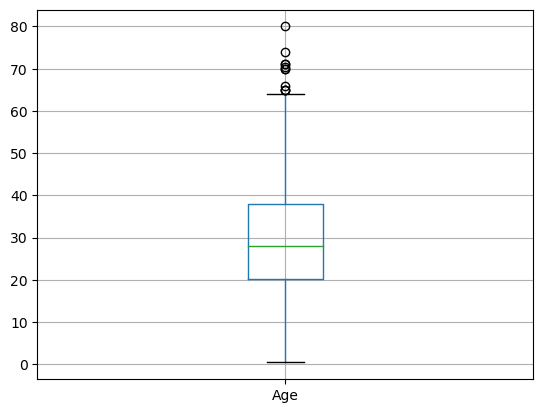

In [7]:
# Age 박스플롯
df.boxplot(['Age']);

Age의 경우 boxplot을 살펴보면 이상치가 있는 것처럼 보입니다. 하지만 위에서 확인했을 때, Age의 max값은 80이었습니다. 80세의 탑승객은 존재할 수 있으므로, 별도의 이상치 처리는 하지 않을 것입니다.

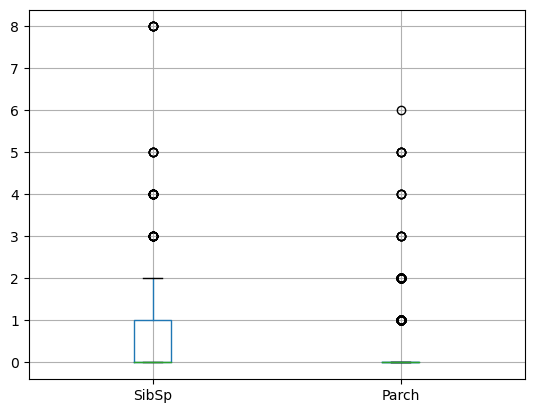

In [8]:
# SibSp와 Parch의 박스플롯
df.boxplot(['SibSp', 'Parch']);

SibSp와 Parch도 이상치가 있는 것처럼 보입니다. 하지만 값이 정수이기때문에 연속적으로 분포하고 있음을 확인할 수 있습니다. 제가 전처리를 어떻게 했는 지는 뒤에서 살펴보도록 하겠습니다.

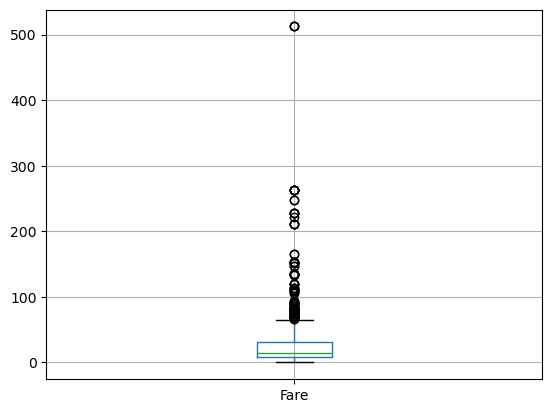

In [9]:
# Fare 박스플롯
df.boxplot(['Fare']);

Fare은 앞에서 살펴본 다른 boxplot과는 다르게 확실히 이상치가 관측됩니다. 이 부분도 어떻게 처리했는 지 뒤에서 확인해보도록 하겠습니다.

# 3. 데이터 전처리

## 3.1. Age의 결측치 대체 + Embarked 결측치 삭제

In [10]:
# Age의 평균값 계산
age_mean = round(df['Age'].mean(), 0)
print(f'Age의 평균 : {age_mean}')

# Age의 결측치를 평균으로 대체
df['Age'] = df['Age'].fillna(age_mean)

Age의 평균 : 30.0


Age의 결측치를 산술 평균으로 대체하였습니다.다른 분들이 작성한 코드를 살펴보면 데이터 내에 정보들을 종합해서 결측치를 대체하는 방법도 쉽게 찾아볼 수 있습니다. 하지만 당시에는 경험이 부족하여 단순히 평균으로 대체하였습니다.\
\
하지만 지금 시점에서도 결측치를 제거하라고 하면 다른 분들처럼 복잡한 방법은 사용하지 않을 것 같습니다. 똑같이 평균으로 대체를 하더라도 그 과정을 납득할 수 있도록 근거를 찾기 위해 노력할 것 같습니다.

In [11]:
df = df.dropna(subset=['Embarked'])

Embarked의 경우에는 결측치인 값이 2개 뿐이기 때문에 제거해주었습니다.

## 3.2. SibSp & Parch 이상치 제거

In [12]:
# SibSp와 Parch의 Z-Score를 새로운 컬럼으로 추가
df['SibSp_Z'] = stats.zscore(df['SibSp'])
df['Parch_Z'] = stats.zscore(df['Parch'])

df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,SibSp_Z,Parch_Z
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0.431350,-0.474326
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0.431350,-0.474326
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,-0.475199,-0.474326
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0.431350,-0.474326
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,-0.475199,-0.474326


In [13]:
# Z-Score가 -3보다 작거나 3보다 큰 데이터 제거
print('삭제 전 데이터의 개수 :', len(df))

df = df[df['SibSp_Z'].between(-2.5, 2.5)]
df = df[df['Parch_Z'].between(-2.5, 2.5)]

# Z-Score 컬럼 제거
df = df.drop(['SibSp_Z', 'Parch_Z'], axis=1)

print('삭제 후 데이터의 개수 :', len(df))
df.describe()

삭제 전 데이터의 개수 : 889
삭제 후 데이터의 개수 : 844


,Survived,Pclass,Age,SibSp,Parch,Fare
count,844.000000,844.000000,844.000000,844.000000,844.000000,844.000000
mean,0.394550,2.279621,30.147121,0.356635,0.268957,31.469095
std,0.489044,0.840839,12.616809,0.638478,0.580370,50.229168
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,23.000000,0.000000,0.000000,7.895800
50%,0.000000,3.000000,30.000000,0.000000,0.000000,13.000000
75%,1.000000,3.000000,35.000000,1.000000,0.000000,28.553125
max,1.000000,3.000000,80.000000,3.000000,2.000000,512.329200


이 당시에는 z-score가 -2.5와 2.5 사이에 존재하는 데이터만 남겨두었습니다. z점수를 사용하여 신뢰구간 99%에 데이터만 남겨둔 것입니다. 그 결과 데이터가 약 50개 정도 삭제되었으며, SibSp의 최댓값은 3, Parch의 최댓값은 2가 되었습니다.\
\
지금 코드를 다시 보는 입장에서, 이 변수는 정규분포가 아니라서 좋은 방법이 아닌 것 같습니다. 아마 이런 방법이 있다는 것을 확인하고, 사용해보고 싶은 마음에 이 코드를 썼던 것 같습니다.\
\
다시 이 데이터를 분석한다면 이런 방법을 사용하지 않고, 데이터가 작기 때문에 이상치라고 판단되는 데이터를 살펴볼 것 같습니다.

---

#### 새롭게 분석해보기

In [14]:
# 데이터 불러오기
temp = pd.read_csv('train.csv')
temp = temp.drop('PassengerId', axis=1)

# SibSp의 값별 개수 확인
temp['SibSp'].value_counts().sort_index()

0    608
1    209
2     28
3     16
4     18
5      5
8      7
Name: SibSp, dtype: int64

새롭게 데이터를 불러와서 SibSp부터 value_counts를 확인해보았습니다.\
SibSp는 타이타닉에 함께 승선한 형제/배우자의 수를 의미하는 변수입니다. SibSp가 큰 데이터부터 순서대로 살펴보도록 하겠습니다.\
\
사실 직관적으로 8명이 함께 탑승한 사람이 1명만 있는 것이 아니라, 7명이 있다는 것은 이들이 한 가족이지 않을까?라고 추측할 수 있고, 5명 역시 한 가족이지 않을까? 라고 추측해볼 수 있습니다. 이를 직접 확인해보는 것입니다.

In [15]:
# SibSp가 8명인 데이터 추출
temp[temp['SibSp']==8]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
159,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
792,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


SibSp가 8명인 데이터를 보니 이름의 성이 모두 동일한 것을 확인할 수 있습니다. 따라서 8이라는 값이 이상치가 아니라는 뜻입니다. 다음으로 SibSp가 5인 데이터를 살펴보도록 하겠습니다.

In [16]:
# SibSp가 5명인 데이터 추출
temp[temp['SibSp']==5]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
59,0,3,"Goodwin, Master. William Frederick",male,11.0,5,2,CA 2144,46.9,NaN,S
71,0,3,"Goodwin, Miss. Lillian Amy",female,16.0,5,2,CA 2144,46.9,NaN,S
386,0,3,"Goodwin, Master. Sidney Leonard",male,1.0,5,2,CA 2144,46.9,NaN,S
480,0,3,"Goodwin, Master. Harold Victor",male,9.0,5,2,CA 2144,46.9,NaN,S
683,0,3,"Goodwin, Mr. Charles Edward",male,14.0,5,2,CA 2144,46.9,NaN,S


이 역시 5명의 성이 모두 동일했습니다. 8과 5는 둘 다 존재할 수 있는 값이었습니다. \
하지만 여기서 한 가지 발견할 수 있는 것이 있습니다. 형제/배우자가 많은 가족은 전부 생존하지 못했다는 것입니다.\
이를 확인해보기 위해 SibSp 값별 생존율을 계산해보도록 하겠습니다.

In [17]:
temp.groupby('SibSp').mean()['Survived'].round(2)

SibSp
0    0.35
1    0.54
2    0.46
3    0.25
4    0.17
5    0.00
8    0.00
Name: Survived, dtype: float64

SibSp가 커질수록 생존율이 낮아지는 것처럼 보입니다. 이에 대해서 상관분석을 한 번 해보겠습니다.

In [18]:
sibsp = [0, 1, 2, 3, 4, 5, 8]
survived = [.35, .54, .46, .25, .17, 0, 0]

# 상관계수와 p-value 계산
corr, p_val = stats.pearsonr(sibsp, survived)

print(f'상관계수 : {corr:.2f},     p-value : {p_val:.2f}')

상관계수 : -0.86,     p-value : 0.01


pearson 상관 분석 결과 두 변수 간에 매우 강한 음의 선형 상관관계가 있으며, 이 관계가 통계적으로 매우 유의함을 알 수 있습니다.다시 말해 형제/배우자의 수가 많을수록 생존율이 낮음을 알 수 있습니다.\
\
따라서 이상치를 처리할 때, SibSp가 3보다 큰 경우에는 3으로 대체하여 0~3 사이의 값을 갖도록 바꿀 것입니다.

In [19]:
temp['SibSp'] = temp['SibSp'].apply(lambda x : x if x<=3 else 3)

Parch의 경우에도 이와 같은 프로세스로 이상치 처리를 했을 것입니다. 이 과정은 생략하도록 하겠습니다.

---

## 3.3. Fare 이상치 제거

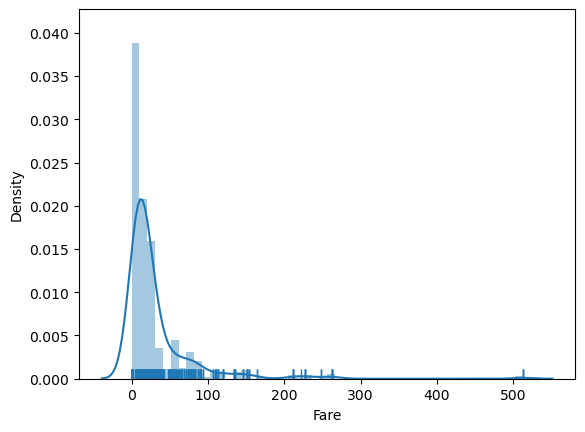

In [20]:
sns.distplot(df['Fare'], rug=True);

그래프를 확인하면 왼쪽으로 치우친 데이터임을 알 수 있습니다. 극단치들을 한 번 확인해보도록 하겠습니다.

In [21]:
# 극단치 확인
df[(df['Fare']<3)|(df['Fare']>300)].sort_values('Fare')

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0000,NaN,S
806,0,1,"Andrews, Mr. Thomas Jr",male,39.0,0,0,112050,0.0000,A36,S
732,0,2,"Knight, Mr. Robert J",male,30.0,0,0,239855,0.0000,NaN,S
674,0,2,"Watson, Mr. Ennis Hastings",male,30.0,0,0,239856,0.0000,NaN,S
633,0,1,"Parr, Mr. William Henry Marsh",male,30.0,0,0,112052,0.0000,NaN,S
597,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0000,NaN,S
815,0,1,"Fry, Mr. Richard",male,30.0,0,0,112058,0.0000,B102,S
481,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,30.0,0,0,239854,0.0000,NaN,S
413,0,2,"Cunningham, Mr. Alfred Fleming",male,30.0,0,0,239853,0.0000,NaN,S
302,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0000,NaN,S


In [22]:
print('삭제 전 데이터의 개수 :', len(df))

# Fare가 0이거나 300 이상인 데이터 삭제
df = df[df['Fare'].between(3, 300)]
print('삭제 후 데이터의 개수 :', len(df))

삭제 전 데이터의 개수 : 844
삭제 후 데이터의 개수 : 826


티켓 가격이 0인 데이터는 삭제하였고, 500인 경우에도 분포와 너무 떨어져있어 삭제하였습니다.\
만약 제가 다시 분석을 한다면 데이터를 바로 삭제하기보다는 대체할 방법을 한 번 찾아보고, 마땅한 방법이 없다면 제 데이터 처리 과정에 근거를 찾아볼 것 같습니다.

## 3.4. 불필요한 컬럼 삭제

In [23]:
df = df.drop(['Cabin', 'Name', 'Ticket'], axis=1)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


Name과 Ticket은 텍스트 데이터로 예측 과정에서 불필요하여 제거하였습니다. 또한 Cabin의 경우 결측치가 많기 때문에 제거하였습니다.

## 3.5. 문자열 인코딩

In [24]:
df = pd.get_dummies(df)
df = df.drop('Sex_female', axis=1)
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,1,0,0,1
1,1,1,38.0,1,0,71.2833,0,1,0,0
2,1,3,26.0,0,0,7.9250,0,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,0,1


female, male과 같이 문자열로 되어있던 Sex 변수와 Embarked 변수를 원핫인코딩 해주었습니다. Sex의 경우에는 값이 2개뿐이기에 female을 가리키는 변수는 제거해주었습니다.

# 4. 모델링 및 생존 결과 예측

## 4.1. 학습, 테스트 데이터 분리

In [25]:
X = df.drop(['Survived'], axis = 1)
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

## 4.2. 변수 정규화

In [26]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

train, test 데이터를 분리한 이후에 MinMaxSclaer를 사용하여 변수를 정규화하였습니다.

## 4.3. 생존 결과 예측

아래부터는 아마 교재에 있는 코드를 따라쳤을 것입니다. 그래서 DecisionTree만 사용하였습니다.

In [27]:
# Decision Tree
df_clf = DecisionTreeClassifier()
df_clf.fit(X_train_sc, y_train)

pred = df_clf.predict(X_test_sc)

print(f'Accuracy : {accuracy_score(y_test, pred):.3f}')

Accuracy : 0.789


In [28]:
# GridSearch CV
clf = DecisionTreeClassifier()
parameters = {'max_depth' : [1, 2, 3, 5, 7], 'min_samples_split' : [2, 3, 4]}
grid_clf = GridSearchCV(clf, param_grid=parameters, cv=5, refit=True)
grid_clf.fit(X_train_sc, y_train)

print('GridSearchCV 최적 파라미터: ', grid_clf.best_params_)
print('GridSearchCV 최고 정확도:{0:.4f}'.format(grid_clf.best_score_))

GridSearchCV 최적 파라미터:  {'max_depth': 2, 'min_samples_split': 2}
GridSearchCV 최고 정확도:0.8182


In [29]:
pred = grid_clf.predict(X_test_sc)
print(f'Accuracy : {accuracy_score(y_test, pred):.3f}')

Accuracy : 0.777


Grid Search CV까지 사용하여 예측한 결과 정확도가 0.8까지 나왔습니다.

--- 

오랜 시간이 지난 후 제가 했던 프로젝트를 리뷰하는데, 첫 프로젝트치고 꽤나 잘 한 것 같습니다 :) 전처리 과정에서 다소 부족한 부분도 있고, 시각화를 통해 인사이트를 발견하는 과정이 없어서 조금 아쉬움이 남습니다. 이제는 Tableu를 배웠기 때문에 파이썬과 태블로를 함께 활용하면서 프로젝트를 진행하는 방향으로 해볼 생각입니다.\
\
그럼 제 첫 프로젝트 복기 게시글은 여기서 마치도록 하겠습니다. 감사합니다.